CNN - TRAFFIC SIGNS

IMPORTING LIBRARIES AND READING THE CSV FILE 

In [17]:
import os
import pandas as pd 

file_path = "/Users/ibhaankudalkar/Downloads/archive/labels.csv"

filename_read = os.path.join(file_path, "/Users/ibhaankudalkar/Downloads/archive/labels.csv")
df = pd.read_csv(filename_read)
print(df)

    ClassId                          Name
0         0           Speed limit (5km/h)
1         1          Speed limit (15km/h)
2         2          Speed limit (30km/h)
3         3          Speed limit (40km/h)
4         4          Speed limit (50km/h)
5         5          Speed limit (60km/h)
6         6          Speed limit (70km/h)
7         7          speed limit (80km/h)
8         8      Dont Go straight or left
9         9     Dont Go straight or Right
10       10              Dont Go straight
11       11                  Dont Go Left
12       12         Dont Go Left or Right
13       13                 Dont Go Right
14       14       Dont overtake from Left
15       15                      No Uturn
16       16                        No Car
17       17                       No horn
18       18          Speed limit (40km/h)
19       19          Speed limit (50km/h)
20       20          Go straight or right
21       21                   Go straight
22       22                       

- IMPORTING PYTORCH LIBRARY
- USING TRANSFORM TO PREPROCESS EACH IMAGE
- RESIZING 32X32 FOR FIXED PIXEL SIZE
- TENSOR TO CONVERT IN PYTORCH METHOD 
- NORMALIZE FOR STANDARD RANGE
- LOAD THE IMAGE DATA
- SPLIT THE DATA AND PREPARE FOR TRAINING 
-  FIRST THREE SAMPLE IMAGES OF OUR DATA IS VIEWED ALONG WITH THEIR CLASS NAMES


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.90588236..0.6784314].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6156863..0.45882356].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7019608..0.7254902].


Number of classes: 58
Train size: 2919
Validation size: 625
Test size: 626
4170


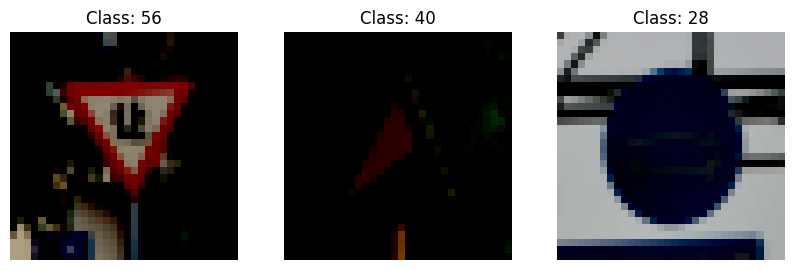

Image shape: torch.Size([3, 32, 32])


In [38]:
# CNN Implementation in pytorch 

import torch
import torch.nn as nn
import torch.nn.functional as F  
import torch.optim 
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# transformation 
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = datasets.ImageFolder(root='/Users/ibhaankudalkar/Downloads/archive/traffic_Data/DATA', transform=transform)
num_classes = len(dataset.classes)
print(f"Number of classes: {num_classes}")

# train test split
train_size = int(0.7 * len(dataset)) # 70
val_size = int(0.15 * len(dataset)) # 15
test_size = len(dataset) - train_size - val_size # 15
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
print("Train size:", train_size)
print("Validation size:", val_size)
print("Test size:", test_size)
print(train_size + val_size + test_size)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Sample of images 
def samples(images, labels, class_names):
    plt.figure(figsize=(10, 4))
    for i in range(len(images)):  
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i].permute(1, 2, 0).numpy())  
        plt.title(f"Class: {class_names[labels[i]]}")
        plt.axis('off')
    plt.show()

# batch of data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# first 3 images
samples(images[:3], labels[:3], dataset.classes)

# print(f"Image shape: {sample_images[0].shape}")


- A CNN CLASS IS DEFINED WITH THREE CONVOLUTIONAL LAYERS 
- MAX POOLING WITH A 2X2 FILTER REDUCING THE SPATIAL DIMENSION BY HALF
- A DENSE LAYER IS USED TO ADJUST THE ACTUAL IMAGE SIZE
- A DROPOUT LAYER WAS ADDED TO MINIMIZE OVERFITTING 

- A FORWARD PASS IS APPLIED TO INPUT X 
- RELU ACTIVATION FUNCTION ON THE THREE CONVOLUTIONAL LAYERS OF INPUT X WITH MAX POOLING 
- X.VIEW FLATTENS THE TENSOR TO 1D VECTOR
- RELU IS APPLIED TO INPUT X TO FLATTEN THE VECTOR AND TO PRODUCE THE LOGITS FOR CLASSIFICATION
- YOU THEN RETURN X

- INITIALIZATION
- CREATE A INSTANCE OF CNN MODEL
- DEFINE THE LOSS FUNCTION 
- ADAM OPTIMIZER IS USED WITH PARAMETERS AND LEARNING RATE 0.001


In [29]:
# CNN MODEL CLASS
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.c1 = nn.Linear(128 * 4 * 4, 512)  
        self.dropout = nn.Dropout(0.5)
        self.c2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4) 
        x = F.relu(self.c1(x))
        self.dropout = nn.Dropout(0.5)
        x = self.c2(x)
        return x

# Initialize the model, criterion, and optimizer
model = CNN(num_classes=num_classes)
criterion = nn.Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


- FUNCTION TRAIN MODEL IS USED TO EVALUATE PERFORMANCE OF EACH EPOCH
- LOOPING THE NUMBER OF EPOCHS TO TRAIN WITH A SMALL BATCH IN THE TRAINING SET 

- VALIDATION LOOP IS USED TO VALIDATE THE LOOPS WITHOUT UPDATING THE WEIGHTS

- PRINT FOR METRICS AFTER EACH EPOCH

- LASTLY CALLS THE TRAIN MODEL FOR 8 EPOCHS

In [39]:
# train model for each epoch
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=8):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Validation step
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        
        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {running_loss/len(train_loader):.4f}, "
              f"Validation Loss: {val_loss/len(val_loader):.4f}, "
              f"Validation Accuracy: {100 * correct / total:.2f}%")

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=8)


Epoch 1/8, Train Loss: 0.1548, Validation Loss: 0.0908, Validation Accuracy: 97.76%
Epoch 2/8, Train Loss: 0.0377, Validation Loss: 0.0383, Validation Accuracy: 98.88%
Epoch 3/8, Train Loss: 0.0099, Validation Loss: 0.0156, Validation Accuracy: 99.36%
Epoch 4/8, Train Loss: 0.0054, Validation Loss: 0.0100, Validation Accuracy: 99.84%
Epoch 5/8, Train Loss: 0.0009, Validation Loss: 0.0053, Validation Accuracy: 99.84%
Epoch 6/8, Train Loss: 0.0007, Validation Loss: 0.0078, Validation Accuracy: 99.68%
Epoch 7/8, Train Loss: 0.0011, Validation Loss: 0.0111, Validation Accuracy: 99.68%
Epoch 8/8, Train Loss: 0.0004, Validation Loss: 0.0042, Validation Accuracy: 99.84%


- FUNCTION TEST MODEL IN EVALUATION ITERATES THROUGH THE TEST DATA 
- PRINTS THE ACCURACY SCORE 
- LASTLY, CALLS THE FUNCTION 

In [40]:
# Testing and Evaluation
def test_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy Score: {100 * correct / total:.2f}%")

test_model(model, test_loader)

Accuracy Score: 99.84%


- SAVE THE TRAINED MODEL

In [44]:
# save the model
torch.save(model, 'model.pth')
print('Saved trained model')

Saved trained model
